In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
import utils
import numpy as np
import time
import json
import os
from batch import GGCNNDATASET
from model import WHOLEMODEL
from dgl.dataloading import GraphDataLoader
from dgl import batch

device = 'cuda:0'

seed = 1 #seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)#让显卡产生的随机数一致
torch.cuda.manual_seed_all(seed)#多卡模式下，让所有显卡生成的随机数一致？这个待验证
np.random.seed(seed)#numpy产生的随机数一致
random.seed(seed)

# CUDA中的一些运算，如对sparse的CUDA张量与dense的CUDA张量调用torch.bmm()，它通常使用不确定性算法。
# 为了避免这种情况，就要将这个flag设置为True，让它使用确定的实现。
torch.backends.cudnn.deterministic = True

# 设置这个flag可以让内置的cuDNN的auto-tuner自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题。
# 但是由于噪声和不同的硬件条件，即使是同一台机器，benchmark都可能会选择不同的算法。为了消除这个随机性，设置为 False
torch.backends.cudnn.benchmark = False
torch.autograd.set_detect_anomaly(True)
torch.set_default_dtype(torch.float64)

In [9]:
dist_path = '/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/202404batch/'

train_data_path = os.path.join(dist_path,'datas/train_data')
test_data_path = os.path.join(dist_path,'datas/test_data')
config_json_file = os.path.join(dist_path, 'datas/config.json')
if not os.path.exists(os.path.join(dist_path, 'results')):
    os.makedirs(os.path.join(dist_path, 'results'), exist_ok=True)
latest_point_path = os.path.join(dist_path, 'results/test_latest.pkl')

with open(config_json_file, 'r', encoding='utf-8') as f:
    config_para = json.load(f)

# configure hyper parameters
batch_size     = config_para['batch_size']
num_epoch      = config_para['num_epoch']
lr_radio_init  = config_para['lr_radio_init']
lr_factor      = config_para['lr_factor']
lr_patience    = config_para['lr_patience']
lr_verbose     = config_para['lr_verbose']
lr_threshold   = config_para['lr_threshold']
lr_eps         = config_para['lr_eps']
min_lr         = config_para['min_lr']
save_frequncy  = config_para['save_frequncy']

reset_all  = config_para['reset_all']
reset_model  = config_para['reset_model']
reset_model_path = config_para['model_path']
reset_opt  = config_para['reset_opt']
reset_sch  = config_para['reset_sch']

# configure trainingset path
trainset_rawdata_path = os.path.join(train_data_path, 'raw')
trainset_dgldata_path = os.path.join(train_data_path, 'dgl')

# configure trainingset path
testset_rawdata_path = os.path.join(test_data_path, 'raw')
testset_dgldata_path = os.path.join(test_data_path, 'dgl')

# configure network structure
gnn_dim_list           = config_para['gnn_dim_list']
gnn_head_list          = config_para['gnn_head_list']
onsite_dim_list        = config_para['onsite_dim_list']
orb_dim_list           = config_para['orb_dim_list']
hopping_dim_list1      = config_para['hopping_dim_list1']
hopping_dim_list2      = config_para['hopping_dim_list2']
expander_bessel_dim    = config_para['expander_bessel_dim']
expander_bessel_cutoff = config_para['expander_bessel_cutoff']
atom_num               = config_para['atom_num']
is_orb                 = config_para['is_orb']

utils.seed_torch(seed = 24)

trainset, traininfos = utils.get_data(
                                        raw_dir = trainset_rawdata_path, 
                                        save_dir = trainset_dgldata_path, 
                                        force_reload = True,
                                        )

traingraphs, trainlabels, init_dim = trainset.get_all()
train_num = len(traingraphs)
traingraphs = batch(traingraphs)
traingraphs = traingraphs.to(device)
train_dataloader = GraphDataLoader(trainset, batch_size = batch_size, drop_last = False, shuffle = False)

testset, testinfos = utils.get_data(
                                        raw_dir = testset_rawdata_path, 
                                        save_dir = testset_dgldata_path, 
                                        force_reload = True,
                                        )

testgraphs, testlabels, init_dim = testset.get_all()
test_num = len(testgraphs)
testgraphs = batch(testgraphs)
testgraphs = testgraphs.to(device)
test_dataloader = GraphDataLoader(testset, batch_size = batch_size, drop_last = False, shuffle = False)

model = WHOLEMODEL(
                    gnn_dim_list = gnn_dim_list,
                    gnn_head_list = gnn_head_list,
                    orb_dim_list = orb_dim_list,
                    onsite_dim_list = onsite_dim_list,
                    hopping_dim_list1 = hopping_dim_list1,
                    hopping_dim_list2 = hopping_dim_list2,
                    expander_bessel_dim = expander_bessel_dim,
                    expander_bessel_cutoff = expander_bessel_cutoff,
                    atom_num=atom_num*batch_size,
                    is_orb = is_orb
                    )

model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr_radio_init, eps=lr_eps)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=lr_factor, patience=lr_patience, verbose=lr_verbose, threshold=lr_threshold, threshold_mode='rel', cooldown=0, min_lr=min_lr, eps=lr_eps)

criterion = nn.SmoothL1Loss()
loss_per_epoch = np.zeros(train_num)  
losses = np.zeros(num_epoch)

if os.path.exists(latest_point_path) and not reset_all:
    checkpoint = torch.load(latest_point_path)
    if not reset_model:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        checkpoint = torch.load(reset_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    if not reset_opt:
        opt.load_state_dict(checkpoint['optimizer_state_dict'])
    if not reset_sch:
        sch.load_state_dict(checkpoint['scheduler_state_dict'])
    loss = checkpoint['loss']
    start_epoch = checkpoint['epoch']
    print('Load epoch {} succeed！'.format(start_epoch))
    if os.path.exists(os.path.join(dist_path, 'results/losses.npy')):
        losses = np.load(os.path.join(dist_path, 'results/losses.npy'))
        if num_epoch > losses.size:
            losses = np.concatenate((losses, np.zeros(num_epoch - losses.size)))
        print('Load train loss succed！')
    else:
        losses = np.zeros(num_epoch)
    if os.path.exists(os.path.join(dist_path, 'results/test_losses.npy')):
        test_losses = np.load(os.path.join(dist_path, 'results/test_losses.npy'))
        if num_epoch > test_losses.size:
            test_losses = np.concatenate((test_losses, np.zeros(num_epoch - test_losses.size)))
        print('Load test loss succed！')
    else:
        test_losses = np.zeros(num_epoch)
else:
    start_epoch = 0
    losses = np.zeros(num_epoch)
    test_losseslosses = np.zeros(num_epoch)
    print('Can not load saved model!Training from beginning!')


para_sk, hopping_index, hopping_info, d, is_hopping, onsite_key, cell_atom_num, onsite_num, orb1_index, orb2_index, orb_num, rvectors, rvectors_all, tensor_E, tensor_eikr, orb_key = utils.batch_index(train_dataloader, traininfos, batch_size)

# print(orb_key)

for epoch in range(start_epoch + 1, num_epoch + 1):
    print(batch_size)
    for graphs, labels in train_dataloader:

        i = int(labels[0] / batch_size)
        # print(orb_num[0])

        hsk, feat, feato = model(graphs, para_sk[i], is_hopping[i], hopping_index[i], orb_key[i], d[i], onsite_key[i], cell_atom_num[i], onsite_num[i].sum(), orb1_index[i], orb2_index[i])

        b1 = int(hsk.shape[0] / len(labels))
        b2 = int(hopping_info[i].shape[0] / len(labels))
        b3 = int(orb_num[i].shape[0] / len(labels))
        b4 = int(cell_atom_num[i] / len(labels))

        loss = 0
        for j in range(len(labels)):
            HR = utils.construct_hr(hsk[j * b1:(j + 1) * b1], hopping_info[i][j * b2:(j + 1) * b2], orb_num[i][j * b3:(j + 1) * b3], b4, rvectors[i][j])

            reproduced_bands = utils.compute_bands(HR, tensor_eikr[i][j])

            loss += criterion(reproduced_bands[:, 4:12], tensor_E[i][j][:, 4:12])

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_per_epoch[i] = loss.item()

        sch.step(loss)

    losses[epoch - 1] = loss_per_epoch.sum() / (train_num - 1)
    
    print("Epoch {:05d} | TrainSet_Loss {:.6f}" . format(epoch, losses[epoch - 1]))

    if epoch % save_frequncy == 0:

        check_point = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'scheduler_state_dict': sch.state_dict(),
                'loss': loss
                }
        torch.save(check_point, os.path.join(dist_path, 'results/test{}.pkl'.format(epoch)))
        
        torch.save(check_point, latest_point_path)

        np.save('losses.npy', losses)


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Can not load saved model!Training from beginning!
32
Epoch 00001 | TrainSet_Loss 1.693306
32
Epoch 00002 | TrainSet_Loss 1.770985
32
Epoch 00003 | TrainSet_Loss 1.656868
32
Epoch 00004 | TrainSet_Loss 1.664341
32
Epoch 00005 | TrainSet_Loss 1.632317
32
Epoch 00006 | TrainSet_Loss 1.629736
32
Epoch 00007 | TrainSet_Loss 1.642523
32
Epoch 00008 | TrainSet_Loss 1.633560
32
Epoch 00009 | TrainSet_Loss 1.621556
32
Epoch 00010 | TrainSet_Loss 1.635825
32
Epoch 00011 | TrainSet_Loss 1.629679
32
Epoch 00012 | TrainSet_Loss 1.622656
32
Epoch 00013 | TrainSet_Loss 1.619454
32
Epoch 00014 | TrainSet_Loss 1.617619
32
Epoch 00015 | TrainSet_Loss 1.616001
32
Epoch 00016 | TrainSet_Loss 1.619636
32
Epoch 00017 | TrainSet_Loss 1.620424
32
Epoch 00018 | TrainSet_Loss 1.615690
32
Epoch 00019 | TrainSet_Loss 1.618864
32
Epoch 00020 | TrainSet_Loss 1.614927
32
Epoch 00021 | TrainSet_Loss 1.611515
32
Epoch 00022 | TrainSet_Loss 1.611816
32
E

KeyboardInterrupt: 

In [4]:
filename, cell_atom_num, atom_num, d, hopping_index, hopping_info, hopping_orbital, is_hopping, onsite_key, onsite_num, orb1_index, orb2_index, orb_key, orb_num, outinfor, para_sk, rvectors, rvectors_all, tensor_E, tensor_eikr = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

In [7]:
def equalize_ndarray(ndarr): #取短补短
    max_length = max(len(row) for row in ndarr)
    equalized_ndarr = np.array([np.concatenate((row, np.zeros(max_length-len(row)))) for row in ndarr])
    return np.float64(equalized_ndarr)

outi = torch.tensor(equalize_ndarray(outi))

In [ ]:
if __name__ == '__main__':
    main(config_json_file = './script_one_shot_config.json', ribbon_wide = 36)

/home/pigz2538/Tools/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pigz2538/Tools/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


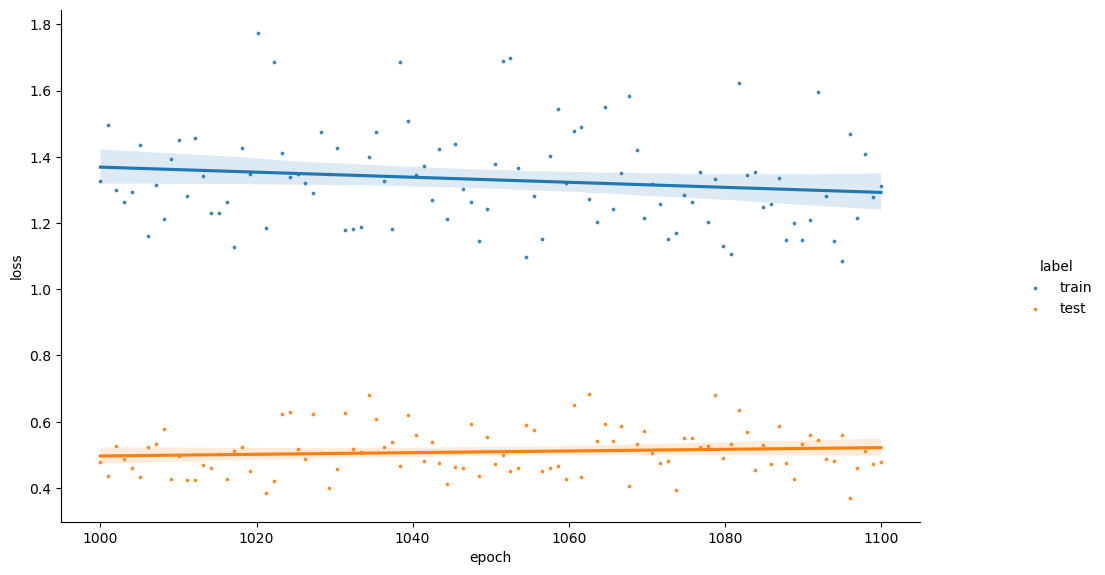

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb


train_loss = np.load('/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/results/losses.npy')
test_loss = np.load('/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/results/test_losses.npy')

start = 1000
end = 1100

x = np.linspace(start, end, end-start)
x = np.concatenate((x,x))
train_label = ['train'] * (end-start)
test_label = ['test'] * (end-start)
labels = train_label + test_label
loss = np.concatenate((train_loss[start:end],test_loss[start:end]))

data = pd.DataFrame({'epoch': x, 'label': labels, 'loss': loss})

# plt.figure(figsize=(18, 16))
sb.set_context({'figure.figsize':[12, 6]})
plot = sb.lmplot(data=data, x='epoch', y='loss', hue='label', scatter_kws={'s': 3})
plot.figure.set_size_inches(12,6)
# plot.legend(markerscale=2)
# plt.plot(loss[800:1500], label='train_loss')
# plt.plot(test_loss[800:1500], label='test_loss')
# plt.legend()
# plt.show()

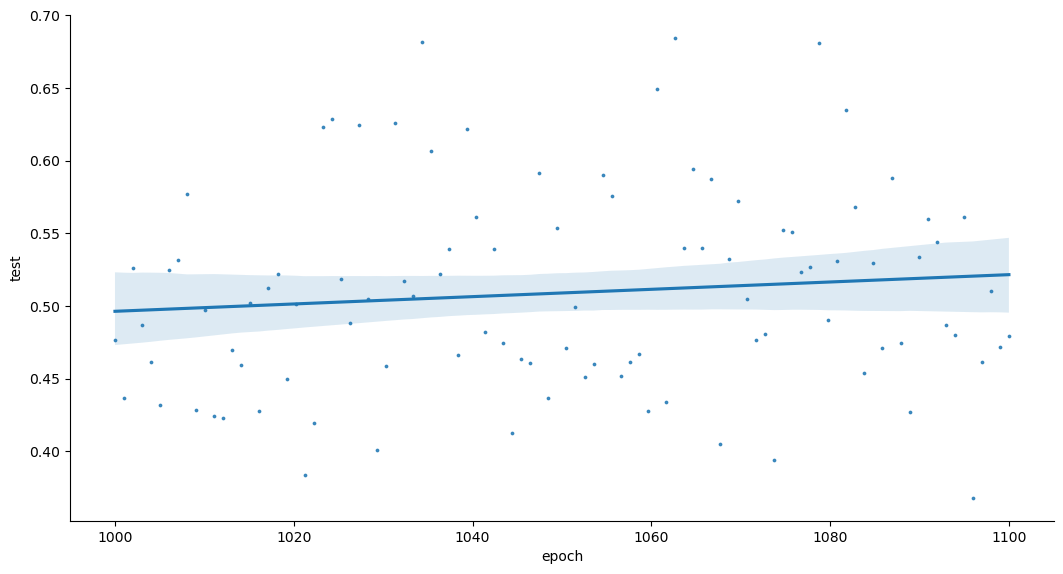

In [2]:
x = np.linspace(start, end, end-start)

data = pd.DataFrame({'epoch': x, 'train': train_loss[start:end], 'test': test_loss[start:end]})

# plt.figure(figsize=(18, 16))
sb.set_context({'figure.figsize':[12, 6]})
plot = sb.lmplot(data=data, x='epoch', y='test', scatter_kws={'s': 3})
plot.figure.set_size_inches(12,6)


In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
import utils
import numpy as np
import time
import json
import os
from batch import GGCNNDATASET
from model import WHOLEMODEL
from dgl.dataloading import GraphDataLoader
from dgl import batch
import readcif as rd

device = 'cuda:0'

seed = 1 #seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)#让显卡产生的随机数一致
torch.cuda.manual_seed_all(seed)#多卡模式下，让所有显卡生成的随机数一致？这个待验证
np.random.seed(seed)#numpy产生的随机数一致
random.seed(seed)

# CUDA中的一些运算，如对sparse的CUDA张量与dense的CUDA张量调用torch.bmm()，它通常使用不确定性算法。
# 为了避免这种情况，就要将这个flag设置为True，让它使用确定的实现。
torch.backends.cudnn.deterministic = True

# 设置这个flag可以让内置的cuDNN的auto-tuner自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题。
# 但是由于噪声和不同的硬件条件，即使是同一台机器，benchmark都可能会选择不同的算法。为了消除这个随机性，设置为 False
torch.backends.cudnn.benchmark = False
torch.autograd.set_detect_anomaly(True)
torch.set_default_dtype(torch.float64)


In [2]:
def predict(path, name, model):
    graphs = []
    labels = []
    infos = {}
    label_count = 0

    max_orbital_num = 14
    max_orbkey_num = 11

    pwd = os.path.join(path, name)


    with open(os.path.join(pwd, name + '.json'), 'r') as f:
        setjson = json.load(f)

    cif_file = os.path.join(pwd, name + '.cif')
    bands = np.load(os.path.join(pwd, 'bands.npy'))
    kpoints = np.load(os.path.join(pwd, 'k_points.npy'))

    calorb = dict(setjson['calorb'])
    graph_s, hopping_info, hopping_orbital, hopping_index, rvectors, rvectors_all, outinfor, onsite_key, orb1_index, orb2_index = rd.read_cif(cif_file, calorb)

    graph_s = graph_s.to(device)

    orb_num = torch.tensor(np.array([x.shape[0] for x in hopping_orbital]))
    atom_num = graph_s.nodes().shape[0]
    init_dim = graph_s.ndata['feature'].shape[1]

    para_sk = utils.get_coefficient(rvectors, hopping_info, hopping_orbital, max_orbital_num, atom_num)

    tensor_E = torch.tensor(bands)
    tensor_K = torch.tensor(kpoints)

    tensor_eikr = utils.get_eikr(kpoints, rvectors_all)
    hopping_info = torch.tensor(hopping_info)
    hopping_index = torch.tensor(hopping_index)

    hopping_infos = hopping_info.repeat_interleave(orb_num, dim=0)
    hopping_indexs = hopping_index.repeat_interleave(orb_num, dim=0)

    rvectors = torch.tensor(rvectors)
    d = hopping_infos[:, 2].reshape([-1,1])
    coord = hopping_infos[:, 10:]
    coord = coord.reshape(-1, 2, 1)
    is_hopping = hopping_infos[:,7]
    
    calorb_num = setjson['calorb_num']
    tmp = list(map(lambda x: x*x, calorb_num))
    onsite_num = np.array(tmp)

    infos = {}
    infos['filename'] = setjson['filename']
    infos['cell_atom_num'] = setjson['cell_atom_num']
    infos['atom_num'] = atom_num
    infos['d'] = torch.tensor(d).to(device)
    infos['hopping_index'] = torch.tensor(hopping_indexs).to(device)
    infos['hopping_info'] = torch.tensor(hopping_info).to(device)
    infos['hopping_orbital'] = hopping_orbital
    infos['is_hopping'] = torch.tensor(is_hopping).to(device)
    infos['onsite_key'] = onsite_key
    infos['onsite_num'] = onsite_num
    infos['orb1_index'] = orb1_index
    infos['orb2_index'] = orb2_index
    infos['orb_key'] = np.array(setjson['orb_key'])
    infos['orb_num'] = orb_num
    infos['outinfor'] = outinfor
    infos['para_sk'] = torch.tensor(para_sk).to(device)
    infos['rvectors'] = torch.tensor(rvectors).to(device)
    infos['rvectors_all'] = torch.tensor(rvectors_all).to(device)
    infos['tensor_E'] = torch.tensor(tensor_E).to(device)
    infos['tensor_eikr'] = torch.tensor(tensor_eikr).to(device)

    hsk, feat, feato = model(graph_s, infos['para_sk'], infos['is_hopping'], infos['hopping_index'], infos['orb_key'], infos['d'], infos['onsite_key'], infos['cell_atom_num'], infos['onsite_num'].sum(), infos['orb1_index'], infos['orb2_index'])

    HR = utils.construct_hr(hsk, infos['hopping_info'], infos['orb_num'], infos['cell_atom_num'], infos['rvectors'])

    reproduced_bands = utils.compute_bands(HR, infos['tensor_eikr'])

    return feat, feato, HR, reproduced_bands, infos['tensor_E']

In [48]:
dist_path = '/media/pigz2538/e30413cf-5429-46b3-8fe9-ea458052c437/文档/tbmodel/'

data_path = os.path.join(dist_path,'datas/train_data/')
config_json_file = os.path.join(dist_path, 'datas/config.json')
if not os.path.exists(os.path.join(dist_path, 'results')):
    os.makedirs(os.path.join(dist_path, 'results'), exist_ok=True)

latest_point_path = os.path.join(dist_path, 'results/test200.pkl')
predict_path = os.path.join(dist_path, 'datas/train_data/raw/')
predict_name = 'ReS2_p6m2'

In [49]:
with open(config_json_file, 'r', encoding='utf-8') as f:
    config_para = json.load(f)

# configure hyper parameters
train_num      = config_para['train_num']
test_num       = config_para['test_num']
batch_size     = config_para['batch_size']
num_epoch      = config_para['num_epoch']
lr_radio_init  = config_para['lr_radio_init']
lr_factor      = config_para['lr_factor']
lr_patience    = config_para['lr_patience']
lr_verbose     = config_para['lr_verbose']
lr_threshold   = config_para['lr_threshold']
lr_eps         = config_para['lr_eps']
min_lr         = config_para['min_lr']
save_frequncy  = config_para['save_frequncy']

# configure trainingset path
trainset_rawdata_path = os.path.join(data_path, 'raw')
trainset_dgldata_path = os.path.join(data_path, 'dgl')

# configure network structure
embedding_dim          = config_para['embedding_dim']
graph_dim              = config_para['graph_dim']
gnn_dim_list           = config_para['gnn_dim_list']
gnn_head_list          = config_para['gnn_head_list']
onsite_dim_list        = config_para['onsite_dim_list']
orb_dim_list           = config_para['orb_dim_list']
hopping_dim_list1      = config_para['hopping_dim_list1']
hopping_dim_list2      = config_para['hopping_dim_list2']
expander_bessel_dim    = config_para['expander_bessel_dim']
expander_bessel_cutoff = config_para['expander_bessel_cutoff']
atom_num               = config_para['atom_num']
is_orb                 = config_para['is_orb']

utils.seed_torch(seed = 24)

testset, testinfos = utils.get_data(
                                        raw_dir = trainset_rawdata_path, 
                                        save_dir = trainset_dgldata_path, 
                                        data_num = test_num,
                                        force_reload = False,
                                        )
model = WHOLEMODEL(
                    embedding_dim = embedding_dim,
                    graph_dim = graph_dim,
                    gnn_dim_list = gnn_dim_list,
                    gnn_head_list = gnn_head_list,
                    orb_dim_list = orb_dim_list,
                    onsite_dim_list = onsite_dim_list,
                    hopping_dim_list1 = hopping_dim_list1,
                    hopping_dim_list2 = hopping_dim_list2,
                    expander_bessel_dim = expander_bessel_dim,
                    expander_bessel_cutoff = expander_bessel_cutoff,
                    atom_num=atom_num,
                    is_orb = is_orb
                    )
criterion = nn.SmoothL1Loss()

1


In [50]:
checkpoint = torch.load(latest_point_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
feat, feato, HR, reproduced_bands, origin_bands = predict(predict_path, predict_name, model.to(device))
# print(traininfos[checkpoint['test_index']]['filename'])
# L1 = 0
# L2 = 0
# for name,param in model.named_parameters():
#     if 'bias' not in name:
#         L1 += torch.norm(param, p=1) * 1e-3
#         L2 += torch.norm(param, p=2) * 1e-3

loss = criterion(reproduced_bands[:, 4:12], origin_bands[:, 4:12])

print(loss.item(), checkpoint['loss'])

1


/tmp/ipykernel_40693/717573922.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infos['d'] = torch.tensor(d).to(device)
/tmp/ipykernel_40693/717573922.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infos['hopping_index'] = torch.tensor(hopping_indexs).to(device)
/tmp/ipykernel_40693/717573922.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infos['hopping_info'] = torch.tensor(hopping_info).to(device)
/tmp/ipykernel_40693/717573922.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clo

0.009228914899228002 tensor(0.0233, device='cuda:0', requires_grad=True)


torch.Size([301, 14]) torch.Size([301, 14])
(301, 8)


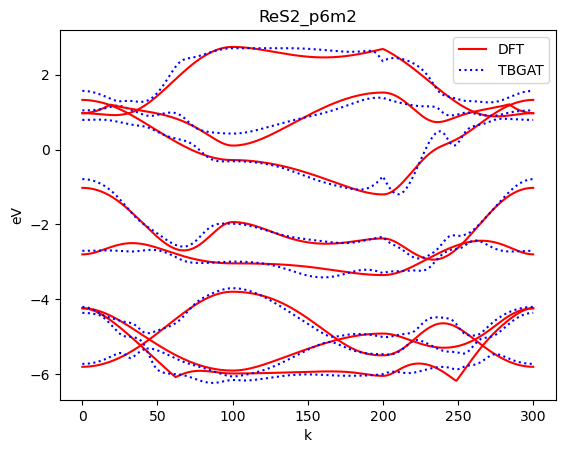

In [51]:
import matplotlib.pyplot as plt

print(origin_bands.shape, origin_bands.shape)
reproduced_band = reproduced_bands.cpu().detach().numpy()[:, 4:12]

reference_bands = origin_bands.cpu().detach().numpy()[:, 4:12]

print(reference_bands.shape)

for i in range(reproduced_band.shape[1]):
    plt.plot(reference_bands[:,i],color = 'r')
    plt.plot(reproduced_band[:,i],color = 'b', ls=':')

plt.xlabel('k')
plt.ylabel('eV')
plt.legend(['DFT', 'TBGAT'])
plt.title(predict_name)
# plt.savefig('/home/pigz2538/桌面/20240330/' + predict_name[:-5] + '-4090.png')
plt.show()

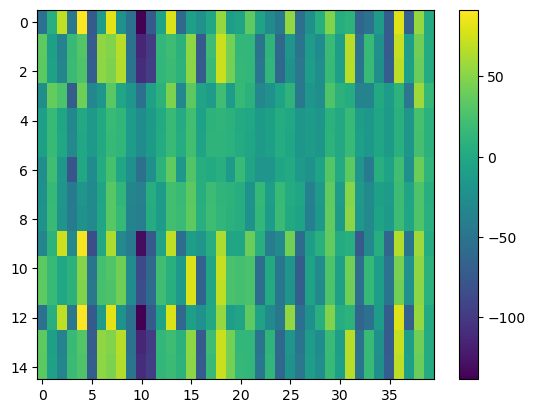

In [52]:
plt.imshow(feat.cpu().detach().numpy(), aspect='auto')
plt.colorbar()

f = plt.gcf()  #获取当前图像
# f.savefig('/media/pigz2538/E2BCC52DBCC4FCD3/Users/z2538/Desktop/111/MoS2-test8/feats.png')
plt.show()

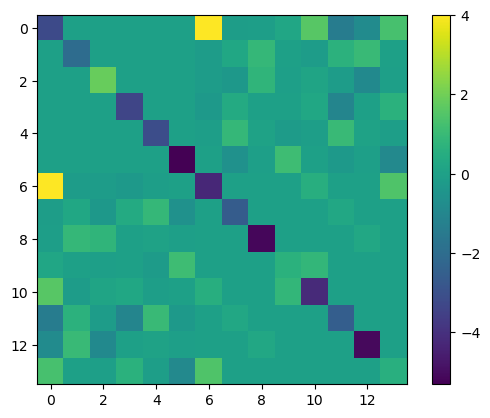

In [58]:
plt.imshow(HR[4].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [11]:
ma, mb = 2, 1

a1, a2, b1, b2 = 4, 5, 6, 7

a = 5

k = 8

In [47]:
from sympy import symbols, Eq, exp, solve, I, latex, sin, cos

# 定义符号
y, x = symbols('y x')

# 定义方程
equation = Eq((ma*y**2-2*k)**2 * (mb*y**2-2*k)**2+k**4*(2-2*cos(4*x*a)), k**2*(ma*y**2+mb*y**2-4*k)**2)

# 解方程
result = solve(equation, y)
result[0]


-Piecewise((sqrt(-2*sqrt(3)*sqrt(-2**(1/3)*(3168*cos(20*x) - 2323)**(1/3) + 22)/3 - 2*sqrt(2**(1/3)*(3168*cos(20*x) - 2323)**(1/3)/3 + 44/3 - 12*sqrt(3)/sqrt(-2**(1/3)*(3168*cos(20*x) - 2323)**(1/3) + 22)) + 12), Eq(cos(20*x), 217/96)), (sqrt(-2*sqrt((12*sqrt(6)*sqrt(1024*cos(20*x)**3 + 4672*cos(20*x)**2 - 1339*cos(20*x) - 5581) - 3168*cos(20*x) + 2323)**(1/3)/3 + 22/3 - 32*cos(20*x)/(12*sqrt(6)*sqrt(1024*cos(20*x)**3 + 4672*cos(20*x)**2 - 1339*cos(20*x) - 5581) - 3168*cos(20*x) + 2323)**(1/3) + 217/(3*(12*sqrt(6)*sqrt(1024*cos(20*x)**3 + 4672*cos(20*x)**2 - 1339*cos(20*x) - 5581) - 3168*cos(20*x) + 2323)**(1/3))) - 2*sqrt(-(12*sqrt(6)*sqrt(1024*cos(20*x)**3 + 4672*cos(20*x)**2 - 1339*cos(20*x) - 5581) - 3168*cos(20*x) + 2323)**(1/3)/3 + 44/3 - 12/sqrt((12*sqrt(6)*sqrt(1024*cos(20*x)**3 + 4672*cos(20*x)**2 - 1339*cos(20*x) - 5581) - 3168*cos(20*x) + 2323)**(1/3)/3 + 22/3 - 32*cos(20*x)/(12*sqrt(6)*sqrt(1024*cos(20*x)**3 + 4672*cos(20*x)**2 - 1339*cos(20*x) - 5581) - 3168*cos(20*x) + 23

In [38]:
print(latex(result[3]))

\begin{cases} \sqrt{- \frac{\sqrt{3} \sqrt{- \sqrt[3]{2} \sqrt[3]{3168 \cos{\left(4 x \right)} - 2323} + 22}}{3} + \sqrt{\frac{\sqrt[3]{2} \sqrt[3]{3168 \cos{\left(4 x \right)} - 2323}}{3} + \frac{44}{3} - \frac{12 \sqrt{3}}{\sqrt{- \sqrt[3]{2} \sqrt[3]{3168 \cos{\left(4 x \right)} - 2323} + 22}}} + 6} & \text{for}\: \cos{\left(4 x \right)} = \frac{217}{96} \\\sqrt{- \sqrt{\frac{\sqrt[3]{12 \sqrt{6} \sqrt{1024 \cos^{3}{\left(4 x \right)} + 4672 \cos^{2}{\left(4 x \right)} - 1339 \cos{\left(4 x \right)} - 5581} - 3168 \cos{\left(4 x \right)} + 2323}}{3} + \frac{22}{3} - \frac{32 \cos{\left(4 x \right)}}{\sqrt[3]{12 \sqrt{6} \sqrt{1024 \cos^{3}{\left(4 x \right)} + 4672 \cos^{2}{\left(4 x \right)} - 1339 \cos{\left(4 x \right)} - 5581} - 3168 \cos{\left(4 x \right)} + 2323}} + \frac{217}{3 \sqrt[3]{12 \sqrt{6} \sqrt{1024 \cos^{3}{\left(4 x \right)} + 4672 \cos^{2}{\left(4 x \right)} - 1339 \cos{\left(4 x \right)} - 5581} - 3168 \cos{\left(4 x \right)} + 2323}}} + \sqrt{- \frac{\sqrt[3]{1

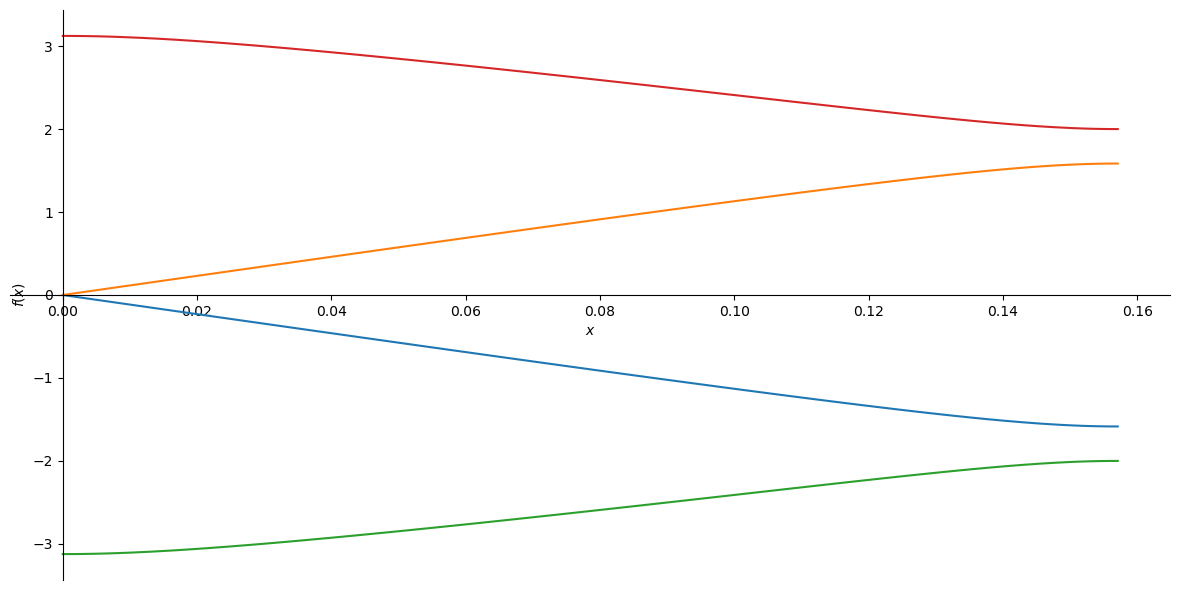

In [48]:
from sympy.plotting import plot
plot(result[0], result[1], result[2], result[3], (x, 0, np.pi/(4*a)))

In [25]:
from sympy import symbols, Eq, exp, solve, I, latex, sin, cos,  Matrix, expand,  simplify

x, y, ma, mb, k, a, a1, a2, b1, b2, alpha = symbols('q omega m_A m_B k a a_1 a_2 b_1 b_2 alpha')


In [18]:
M = Matrix([[ma*y**2-2*k, k*exp(I*x*a), 0, k*exp(-I*x*a)],
            [k*exp(-I*x*a), ma*y**2-2*k, k*exp(I*x*a), 0],
            [0, k*exp(-I*x*a), mb*y**2-2*k, k*exp(I*x*a)],
            [k*exp(I*x*a), 0, k*exp(-I*x*a), mb*y**2-2*k]])
M

Matrix([
[-2*k + m_A*omega**2,        k*exp(I*a*q),                   0,       k*exp(-I*a*q)],
[      k*exp(-I*a*q), -2*k + m_A*omega**2,        k*exp(I*a*q),                   0],
[                  0,       k*exp(-I*a*q), -2*k + m_B*omega**2,        k*exp(I*a*q)],
[       k*exp(I*a*q),                   0,       k*exp(-I*a*q), -2*k + m_B*omega**2]])

In [37]:
det_expanded = expand(M.det())
simplify(det_expanded)

-k**4*exp(4*I*a*q) + 2*k**4 - k**4*exp(-4*I*a*q) - 8*k**3*m_A*omega**2 - 8*k**3*m_B*omega**2 + 3*k**2*m_A**2*omega**4 + 14*k**2*m_A*m_B*omega**4 + 3*k**2*m_B**2*omega**4 - 4*k*m_A**2*m_B*omega**6 - 4*k*m_A*m_B**2*omega**6 + m_A**2*m_B**2*omega**8

In [27]:

det_expanded_divided = simplify(det_expanded / k**4)
det_expanded_sub = det_expanded_divided.subs(x**2/k, alpha)
det_expanded_sub

-2*cos(4*a*q) + 2 - 8*m_A*omega**2/k - 8*m_B*omega**2/k + 3*m_A**2*omega**4/k**2 + 14*m_A*m_B*omega**4/k**2 + 3*m_B**2*omega**4/k**2 - 4*m_A**2*m_B*omega**6/k**3 - 4*m_A*m_B**2*omega**6/k**3 + m_A**2*m_B**2*omega**8/k**4

In [29]:
from sympy import symbols, Eq, exp, solve, I, latex, sin, cos,  Matrix, expand,  simplify

x, y, ma, mb, a, a1, a2, b1, b2 = symbols('alpha m_A m_B a a_1 a_2 b_1 b_2')

In [30]:
equation = Eq((x**4)*(ma*mb)**2-4*(x**3)*ma*mb*(ma+mb)+(x**2)*(3*(ma**2)+14*ma*mb+3*(mb**2))-8*x*(ma+mb), 0)
result = solve(equation, x)

In [36]:
result[3]

(3*m_A + 3*m_B + sqrt(9*m_A**2 - 14*m_A*m_B + 9*m_B**2))/(2*m_A*m_B)

In [5]:
import random

aa = ['rgre', 'ad', 'adwdaw', 'adwa', 'awdaw']

random.choices(aa, k=3)

['ad', 'adwa', 'ad']